In [1]:
import pandas as pd
import pandahouse
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from read_db.CH import Getch

q = """
SELECT exp_group, 
       user_id,
       countIf(action = 'like') as likes,
       countIf(action = 'view') as views,
       likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-04-04' and '2022-04-10'
        and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = Getch(q, db='simulator_20220420').df
df.head(10)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
5,2,131473,14,134,0.104478
6,2,23985,7,87,0.080460
7,2,24523,11,101,0.108911
8,2,32420,26,128,0.203125
9,2,24239,40,90,0.444444


In [2]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


<AxesSubplot:xlabel='ctr', ylabel='Count'>

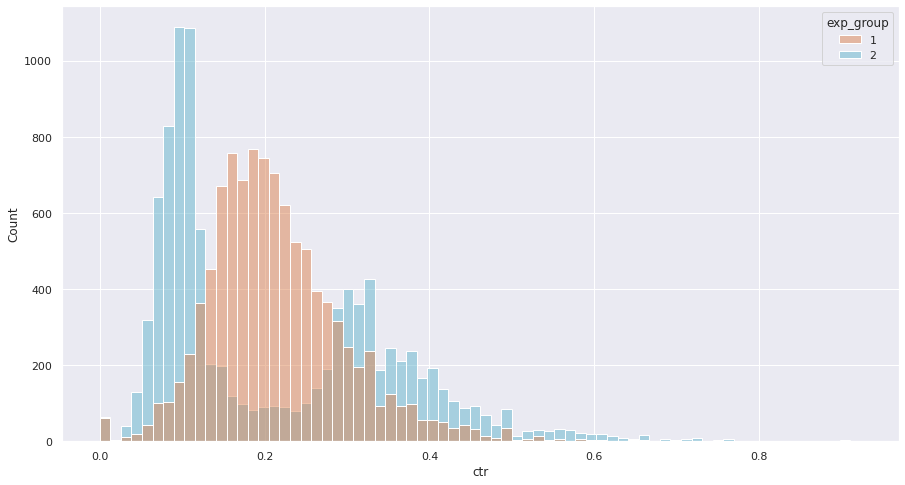

In [3]:
sns.set()
plt.figure(figsize = (15,8))
sns.histplot(data = df, x = 'ctr', hue ='exp_group', palette=["C1", "C9"]) # бимодальное распределние группы 2

### T-test

In [14]:
cg = df[df['exp_group'] == 1]
tg = df[df['exp_group'] == 2]

In [15]:
print(cg.ctr.mean(), tg.ctr.mean()) #среднее почти не отличается 

0.21560459841296287 0.21441927347479375


In [17]:
stats.ttest_ind(tg.ctr,
                cg.ctr,
                equal_var=False)    # по результатам Т-теста мы как будто бы не можем отвергнуть гипотезу,
                                    # что средние равны - отличий нет. Однако, имея в распределении большие по модулю отклонения
                                    # (жирные выбросы — часть распределения), мы также не можем быть уверены в 
                                    # корректности работы теста. 

Ttest_indResult(statistic=-0.7094392041270485, pvalue=0.4780623130874935)

### MW_test

In [18]:
print(cg.ctr.median(), tg.ctr.median()) #  медианные значения отличаются

0.203125 0.1428571428571428


In [19]:
stats.mannwhitneyu(cg.ctr, 
                   tg.ctr,
                   alternative = 'two-sided') # получив такое pvalue, мы должны опровергуть нашу нулевую
                                              # гипотезу что A>B = B>A d в наших группах

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

### Poison bootstrap

In [25]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [29]:
likes1 = cg.likes.to_numpy()
views1 = cg.views.to_numpy()
likes2 = tg.likes.to_numpy()
views2 = tg.views.to_numpy()

In [30]:
ctr_cg, ctr_tg = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

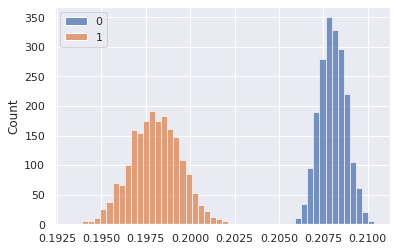

In [31]:
sns.histplot([ctr_cg, ctr_tg], bins=50) #  CTR контрольной группы больше

### Вывод:
Сравнив результаты Т-теста, МУ-теста и пуассоновского бутстрепа, а также, взглянув на графики CTR, можно сделать вывод что CTR группы 2 стал хуже. 
### Рекомендации:
Доработать агоритм, потому что график сдвинулся вправо, однако стал бимодальным.